<br><br>

<center><u><font size="5" color="blue">Final Presentation : Cholesky Decomposition and Monte Carlo- Team MBA 50s</font></u></center>



<br>

### Table of Contents

* [Steps](#steps)
* [QuantPy](#quantpy)
* [Linear Algebra Review](#review)
* [Step by Step](#demonstration)
* [Monte Carlo Simulation](#mc)  
    
<br>

<pre>

    The Cholesky decomposition is commonly used in the Monte Carlo method for simulating systems with multiple correlated variables. 
    
    
</pre>

<br><br>

<center><font size="5" color="blue"><u>Steps</u></font></center><a class="anchor" id="steps"></a>

<br><br>


1. Create a covariance matrix based on the price history of each instrument

2. Perform Cholesky decomposition on that matrix to create a Lower Triangular matrix.

3. Create a schotastic parameter with the inner product of above and a random sampling of normal standard deviations.

4. Apply the schotastic parameter to the average change of each instrument.

5. Finally qualify that by the weight of each instrument and by the initial market value.

6. Use cumsum to get the final 

<br><br>



<br><br>

<center><font size="5" color="blue"><u>QuantPy</u></font></center><a class="anchor" id="quantpy"></a>

<br><br>



<br><br>

The inspiration for this presentation comes from this <b><i>[QuantPy](https://www.youtube.com/watch?v=6-dhdMDiYWQ&list=PLqpCwow11-OqqfELduCMcRI6wcnoM3GAZ)</i></b> presentation. 


<br>

The source code in this presentation is only slightly modified, so the true source is here [here](https://quantpy.com.au/monte-carlo/monte-carlo-as-a-tool-for-financial-math/)

<br>

Note all of our functions are using numpy. I mention this because dataframes and numpy arrays often behave differently
when accessing, printing, formatting, etc..

<br>

We will make use of the following numpy functions : `linalg.cholesky, inner, full and cumprod.`

<br>


The last time we used Monte Carlo on our portfolio we used the pandas_montecarlo package which leveraged
pandas dataframe inheritence methodology to process the history into a random sampling.

<br>

Specifically it called `series.sample(frac=1).values` to produce a series of random price changes that result
in the same end value, but the paths were randomly distributed.


<br><br>


<br><br><br><br>


<hr>

<br><br>

<center><font size="5" color="blue"><u>Linear Algebra Review</u></font></center><a class="anchor" id="review"></a>

<br><br>

<br>

<hr>


<br>


<br>

<b>Gaussian Elimination</b>

<pre>
         Use a sequence of elementary row operations to modify the matrix until the lower left-hand corner
         of the matrix is filled with zeros. The three types of elementary row operations are:

            1) Swapping two rows
            2) Multiplying a row by a nonzero number
            3) Adding a multiple of one row to another row
            
</pre>


<br>

<b>LDU Decomposition</b>

<pre>
        Factors out a square matrix into a lower, upper and diagonal components.
            
</pre>

For example :

<br>

In [228]:
from scipy.linalg import lu
import numpy as np

A_ex = np.array([[2, 5, 8, 7], [5, 2, 2, 8], [7, 5, 6, 6], [5, 4, 4, 8]])
D_ex, L_ex, U_ex = lu(A_ex)

print('\n' * 4)
print("               Matrix A_ex ")
print("               ----------- ")
print("")
for a in A_ex:
    print("{:>10.2f} {:>10.2f}  {:>10.2f} {:>10.2f}".format(*a,))

  
print('\n' * 4)
print("               Matrix L_ex ")
print("               ----------- ")
print("")
for a in L_ex:
    print("{:>10.2f} {:>10.2f}  {:>10.2f} {:>10.2f}".format(*a,))

print('\n' * 4)
print("               Matrix U_ex ")
print("               ----------- ")
print("")
for a in U_ex:
    print("{:>10.2f} {:>10.2f}  {:>10.2f} {:>10.2f}".format(*a,))

print('\n' * 4)

# prove they are factors
# note @ is the matrix dot product operator, this is the same as    np.dot(D_ex,np.dot(L_ex,U_ex))
proof_ex = D_ex @ L_ex @ U_ex

print("               Matrix D_ex @ L_ex @ U_ex ")
print("               --------------------------")
print("")
for a in proof_ex:
    print("{:>10.2f} {:>10.2f}  {:>10.2f} {:>10.2f}".format(*a,))
    
print("")   

print("Note the shape of these matrices are all ", U_ex.shape)

print('\n' * 4)






               Matrix A_ex 
               ----------- 

      2.00       5.00        8.00       7.00
      5.00       2.00        2.00       8.00
      7.00       5.00        6.00       6.00
      5.00       4.00        4.00       8.00





               Matrix L_ex 
               ----------- 

      1.00       0.00        0.00       0.00
      0.29       1.00        0.00       0.00
      0.71       0.12        1.00       0.00
      0.71      -0.44       -0.46       1.00





               Matrix U_ex 
               ----------- 

      7.00       5.00        6.00       6.00
      0.00       3.57        6.29       5.29
      0.00       0.00       -1.04       3.08
      0.00       0.00        0.00       7.46





               Matrix P_ex @ L_ex @ U_ex 
               --------------------------

      2.00       5.00        8.00       7.00
      5.00       2.00        2.00       8.00
      7.00       5.00        6.00       6.00
      5.00       4.00        4.00       8.00

Not

<br>

However Monte Carlo is better served by using the Cholesky decomposition which is computationally more efficient.

<br>

Not every matrix can be decomposed using Cholesky. The matrix needs to be a <b><i>positive definite</i></b> matrix.

<br>

That is it should be of the form

<br>

$$A = A^T$$

<br>

and the lower trianglulation will reveal

<br>

$$A= L * L^T$$

<br>

Fortunately a covariance matrix by definition is a <b><i>positive definite</i></b> matrix.

<br>


<br><br><br><br>


<hr>

<br><br>

<center><font size="5" color="blue"><u>Step by Step Demonstration</u></font></center><a class="anchor" id="demonstration"></a>

<br><br>

<br>

<hr>


<br>

We will apply the math just once on 3 instruments to gain some understanding on how Cholesky decomposition works and how the schochastic application is done. Then well run Monte Carlo.

<br>

In [229]:

stockList = ['GOOG', 'IBM', 'ADP']

T = 100 # of days in the future we are simulating

<br>

Import libraries. Create the function to download the price history and create the covariance matrix.

<br>

Note we are using the series `pct_change()` function to translate daily prices to daily price changes.

<br>

In [73]:
# import math                       is this used ?

import pandas as pd
import datetime
# import scipy.stats as stats        is this used ?
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr


# import data
def get_data(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start, end)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    closePrices = stockData[-1:]
    return closePrices, meanReturns, covMatrix


stocks = [stock for stock in stockList]

endDate = datetime.datetime.now()
startDate = endDate - datetime.timedelta(days=300)

closePrices, meanReturns, covMatrix = get_data(stocks, startDate, endDate)

<br>

Recall a covariance matrix indicates how much each instrument varies from another instrument. The diagonal
represents the variance of that instrument.

<br>

Below we are demonstrating that covariance matrix A and lower triangulation L have the aforementioned properties suitable so we know our Choleskly matrix is good.

<br>

In [75]:
A=np.array(covMatrix)
L = np.linalg.cholesky(covMatrix)  



print('\n' * 4)
print("          Covariance Matrix A ")
print("          ------------------- ")
print("")
for a in A:
    print("{:>10.5f} {:>10.5f}  {:>10.5f}".format(*a,))

  
print('\n' * 4)
print("               Matrix L ")
print("               -------- ")
print("")
for a in L:
    print("{:>10.5f} {:>10.5f}  {:>10.5f}".format(*a,))

B=L.dot(L.T)
    
print('\n' * 4)
print("               Matrix L * L.T ")
print("               -------------- ")
print("")
for a in B:
    print("{:>10.5f} {:>10.5f}  {:>10.5f}".format(*a,))








               Covariance Matrix A 
               ------------------- 

   0.00064    0.00016     0.00030
   0.00016    0.00023     0.00013
   0.00030    0.00013     0.00029





               Matrix L 
               -------- 

   0.02525    0.00000     0.00000
   0.00616    0.01398     0.00000
   0.01184    0.00431     0.01158





               Matrix L * L.T 
               -------------- 

   0.00064    0.00016     0.00030
   0.00016    0.00023     0.00013
   0.00030    0.00013     0.00029


<br>

Next we create a matrix of random Z scores, that is deviatons from a mean. This is our schocastic component.

<br>

In [223]:
Z = np.random.normal(size=(T, len(weights)))

print('\n' * 4)
print("                Matrix Z (Random Z-Scores) ")
print("                -------------------------- ")
print("")

for a in Z[0:5]:
    print("{:>12,.5f} {:>12,.5f} {:>12,.5f}  ".format(*a))

print("{:>12} {:>12} {:>12}  ".format('...','...','...'))   
print('\n' * 4)

print("Note the shape of Z is ", Z.shape)

print('\n' * 4)







                Matrix Z (Random Z-Scores) 
                -------------------------- 

     0.45402      0.95290      0.85473  
     0.26206     -0.51213      0.90185  
     1.27740      0.12142      0.13771  
    -1.27321     -0.68907     -2.95967  
    -2.03882      1.42607      0.87161  
         ...          ...          ...  





Note the shape of I is  (100, 3)







<br>

Next we create an inner matrix of L and Z. The result is a combination of covariance + random deviations.

<br>

In [216]:
I = np.inner(L, Z) 

print('\n' * 4)

print("                Matrix I (Random ZScores + Covariance) ")
print("                -------------------------------------- ")
print("")

for a in I:
    print("{:>12,.5f} {:>12,.5f} {:>12,.5f} {:>12,.5f} {:>12,.5f} ... ".format(*a))
    
print('\n' * 4)

print("Note the shape of I is ", I.shape)

print('\n' * 4)







                Matrix I (Random ZScores + Covariance) 
                -------------------------------------- 

     0.01511      0.00757      0.01204     -0.01929     -0.01213 ... 
    -0.01993     -0.00902     -0.00793      0.00409     -0.01848 ... 
     0.01196      0.00492     -0.01715     -0.00161     -0.02231 ... 





Note the shape of I is  (3, 100)







<br>

Next we allocate the total value of each instrument into a total of 1. This <i>weights</i> our results.

<br>

In [195]:
adp_mv=5200 * closePrices['ADP'][0]
goog_mv=1000 * closePrices['GOOG'][0]
ibm_mv=2500 * closePrices['IBM'][0]
weights = [adp_mv, goog_mv, ibm_mv]

initial_mv = sum(weights)

print('\n' * 4)

print("Individual Market Values (weights) =     {:>10,.0f} {:>10,.0f} {:>10,.0f}".format(*weights), sep='\n')
print("Portfolio Market Value =                 {:>10,.0f}".format(initial_mv))

weights /= np.sum(weights)         # scale them so they add up to 1

print("Weight Allocations =                     {:>9.0f}% {:>9.0f}% {:>9.0f}%".format(*weights*100))

print('\n' * 4)






Individual Market Values (weights) =      1,374,516     97,655    371,471
Portfolio Market Value =                  1,843,642
Weight Allocations =                            75%         5%        20%







<br>

Next we create a matrix of the mean returns across each day in the simulations. In this case its a 3x100 array with the means of Google, ADP, IBM repeating for 100 days.

<br>

In [214]:
print('\n' * 4)

M = np.full(shape=(T, len(weights)), fill_value=meanReturns)
M = M.T


print('\n' * 4)

print("      Matrix M ")
print("     --------------- ")
print("")

for a in M:
    print("{:>12,.5f} {:>12,.5f} {:>12,.5f} {:>12,.5f} {:>12,.5f} ... ".format(*a))
    
print('\n' * 4)


print("Note the shape of M is ", M.shape)

print('\n' * 4)













      Matrix M 
     --------------- 

-0.00127   -0.00127   -0.00127  
0.00063    0.00063    0.00063   
0.00135    0.00135    0.00135   





Note the shape of M is  (3, 100)







<br>

Next we create simulated daily return for all instruments by adding I to the mean

<br>

In [230]:
DR = M + I


print('\n' * 4)

print("      Matrix DR (Mean Return + Inner (ZScore * Covariance) ")
print("     ----------------------------------------------------- ")
print("")

for a in DR:
    print("{:>12,.5f} {:>12,.5f} {:>12,.5f} {:>12,.5f} {:>12,.5f} ... ".format(*a))

    
print('\n' * 4)


print("Note the shape of DR is ", DR.shape)

print('\n' * 4)






      Matrix DR (Mean Return + Inner (ZScore * Covariance) 
     ----------------------------------------------------- 

     0.01384      0.00630      0.01077     -0.02056     -0.01340 ... 
    -0.01930     -0.00838     -0.00730      0.00472     -0.01784 ... 
     0.01331      0.00627     -0.01581     -0.00027     -0.02096 ... 





Note the shape of DR is  (3, 100)







<br>

Finally we aggregate each daily return and multiply it by the initial portfolio market value.

<br>

In [233]:
daily_mvs = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initial_mv

print("\nNote the shape of daily_mvs is ", daily_mvs.shape, end='\n\n\n')

for a in daily_mvs[0:5]:
    print("{:<10,.0f}  ".format(a))

print("...")

for a in daily_mvs[95:]:
    print("{:<10,.0f}  ".format(a))
    


print("\nFinal value after ", T, " days is {:<10,.0f} \n".format(daily_mvs[-1,]) )


Note the shape of daily_mvs is  (100,)


1,848,762   
1,810,865   
1,782,876   
1,777,491   
1,772,353   
...
1,616,723   
1,638,633   
1,607,800   
1,648,489   
1,667,539   

Final value after  100  days is 1,667,539  



<br><br><br><br>


<hr>

<br><br>

<center><font size="5" color="blue"><u>Run Monte Carlo</u></font></center><a class="anchor" id="mc"></a>

<br><br>

<br>

<hr>


In [234]:
path=r'C:\Users\arono\source\python\DATA618\Portfolio'
file='Portfolio.xlsx'
path_and_file=path + "\\" + file
portfolio_df = pd.read_excel(path_and_file)

In [235]:
portfolio_df.insert(9, "Price", 0.0, True)
portfolio_df.insert(10, "MarketValue", 0.0, True)

In [243]:
# remove Cash and CP
tickers=portfolio_df['Ticker']
tickers = tickers.loc[(tickers != 'Cash') & (tickers != 'CP')]

0      MUB
1      ADP
2     GOOG
3      IBM
4      TLT
5     MTGP
6     NETL
7     NUGO
8     NUHY
9     VTIP
10    AEMB
Name: Ticker, dtype: object

In [244]:
closePrices, meanReturns, covMatrix = get_data(tickers, startDate, endDate)

In [264]:
portfolio_df = portfolio_df.set_index(portfolio_df.Ticker)

In [283]:
for ticker in tickers:
    shares=portfolio_df.loc[ticker,'Shares']
    price=closePrices[ticker][0]
    portfolio_df.loc[ticker,'Price']=price
    portfolio_df.loc[ticker,'MarketValue']=shares*price


    # note MarketValue.sum() excludes Cash and CP
tot_mv_initial=portfolio_df.MarketValue.sum()
tot_mv_initial_str="${:,.0f}".format(total_market_value)
print("Total Initial portfolio value ", tot_mv_initial_str)
    
    
for ticker in tickers: 
        market_value=portfolio_df.loc[ticker,'MarketValue']
        portfolio_df.loc[ticker,'Allocation']=market_value/tot_mv_initial

weights=portfolio_df['Allocation']
portfolio_df[['Ticker','Shares','MarketValue', 'Price', 'Allocation']]

Total Initial portfolio value  $81,617,244


,Ticker,Shares,MarketValue,Price,Allocation
Ticker,,,,,
MUB,MUB,2500,2.636250e+05,105.449997,0.003230
ADP,ADP,5200,1.372540e+06,263.950012,0.016817
GOOG,GOOG,1000,9.760000e+04,97.599998,0.001196
IBM,IBM,2500,3.709250e+05,148.369995,0.004545
TLT,TLT,6000,6.174000e+05,102.900002,0.007565
MTGP,MTGP,1500,6.555000e+04,43.700001,0.000803
NETL,NETL,10000,2.628000e+05,26.280001,0.003220
NUGO,NUGO,4000,7.380000e+04,18.450001,0.000904
NUHY,NUHY,2500,5.167250e+04,20.669001,0.000633


In [286]:
mc_sims=100
portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

for m in range(0, mc_sims):
    L = np.linalg.cholesky(covMatrix) 
    Z = np.random.normal(size=(T, len(tickers)))
    I = np.inner(L, Z) 
    M = np.full(shape=(T, len(tickers)), fill_value=meanReturns)
    M = M.T
    DR = M + I
    daily_mvs = np.cumprod(np.inner(weights, DR.T)+1)*tot_mv_initial
    portfolio_sims[:,m] = daily_mvs/1000000


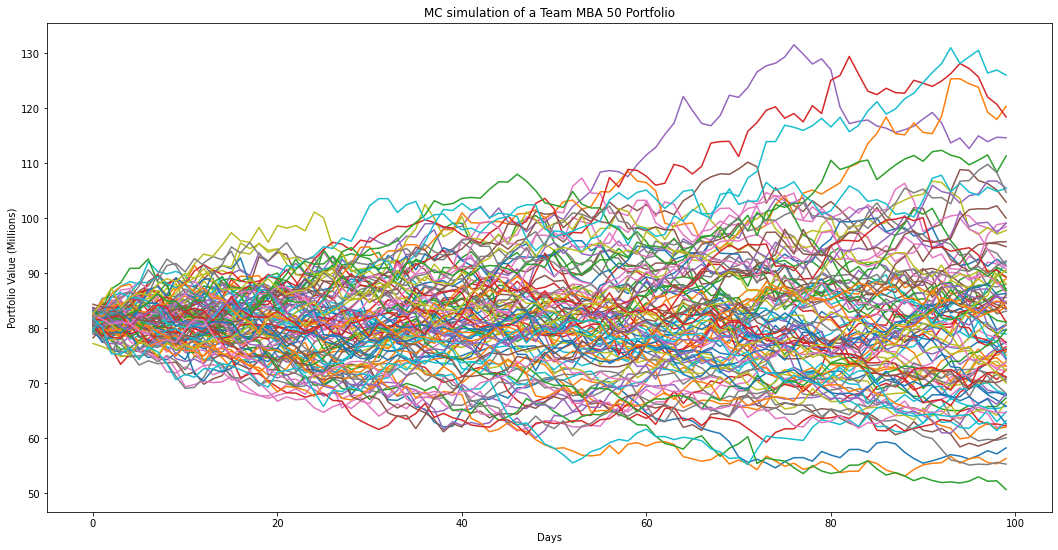

In [287]:
plt.figure(figsize=(18, 9))  
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value (Millions)')
plt.xlabel('Days')
plt.title('MC simulation of a Team MBA 50 Portfolio')
plt.show()


In [288]:
# to do format and multiply by 1MM

portResults=portfolio_sims[-1,:]

print("The best result is ", np.max(portResults))
print("The worst result is ", np.min(portResults))
print("VAR using 95% CI is ", np.percentile(portResults,.05))




The best result is  126.06093265555036
The worst result is  50.63065640649245
VAR using 95% CI is  50.859738528102426
